In [145]:
import os
import random
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.legacy import Adam
import matplotlib.pyplot as plt

# ─── Reproducibility ─────────────────────────────────────────────────────────
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)


In [146]:
# ─── 1) Load & shuffle dataset ───────────────────────────────────────────────
data = np.load('threebody_dataset2.npz')
X_all    = data['X']            # (N_runs, TIMESTEPS, 6)
masses   = data['masses']       # (N_runs, 3)
init_pos = data['init_pos']     # (N_runs, 3, 2)
init_vel = data['init_vel']     # (N_runs, 3, 2)

X_all, masses, init_pos, init_vel = shuffle(
    X_all, masses, init_pos, init_vel,
    random_state=SEED
)


In [147]:
# ─── 2) Conditioning & build_inputs (same as before) ─────────────────────────
def prepare_conditioning(idx):
    pos = init_pos[idx].copy()
    vel = init_vel[idx].copy()
    m   = masses[idx]
    M   = m.sum()
    xcm = (pos[:,0] * m).sum() / M
    ycm = (pos[:,1] * m).sum() / M
    vxcm = (vel[:,0] * m).sum() / M
    vycm = (vel[:,1] * m).sum() / M
    pos[:,0] -= xcm; pos[:,1] -= ycm
    vel[:,0] -= vxcm; vel[:,1] -= vycm
    return np.hstack([m, pos.flatten(), vel.flatten()])  # (15,)

def build_inputs(idx):
    traj     = X_all[idx]                   
    cond_vec = prepare_conditioning(idx)    
    cond_rep = np.repeat(cond_vec[None,:], traj.shape[0], axis=0)  
    return np.hstack([traj, cond_rep])  


In [148]:
# ─── 3) Train/Val/Test splits & params ──────────────────────────────────────
N = len(X_all)
TRAIN_END = int(0.7 * N)
VAL_END   = int(0.85 * N)

train_idx = list(range(0, TRAIN_END))
val_idx   = list(range(TRAIN_END, VAL_END))
test_idx  = list(range(VAL_END, N))

WASHOUT = 100
TIMESTEPS = X_all.shape[1]
INPUT_DIM = 6 + 15
TARGET_DIM = 6

# Build and stack
def stack_data(idxs):
    Xs = np.vstack([build_inputs(i)[:-1] for i in idxs])
    Ys = np.vstack([X_all[i,1:,:]       for i in idxs])
    # reshape to (n_runs*timesteps, features)
    return Xs, Ys

X_train, Y_train = stack_data(train_idx)
X_val,   Y_val   = stack_data(val_idx)
X_test,  Y_test  = stack_data(test_idx)

In [149]:
# ─── 4) Scale inputs & targets ──────────────────────────────────────────────
in_scaler = StandardScaler().fit(X_train)
tg_scaler = StandardScaler().fit(Y_train)

X_train_s = in_scaler.transform(X_train)
Y_train_s = tg_scaler.transform(Y_train)

X_val_s   = in_scaler.transform(X_val)
Y_val_s   = tg_scaler.transform(Y_val)

X_test_s  = in_scaler.transform(X_test)
Y_test_s  = tg_scaler.transform(Y_test)

# reshape for LSTM: (samples, timesteps, features)
def reshape_for_lstm(X, feature_dim):
    # X.shape[0] == n_sequences * (TIMESTEPS-1)
    n_seqs = X.shape[0] // (TIMESTEPS-1)
    return X.reshape(n_seqs, TIMESTEPS-1, feature_dim)

# Then later:

X_train_s = reshape_for_lstm(X_train_s, INPUT_DIM)
Y_train_s = reshape_for_lstm(Y_train_s, TARGET_DIM)

X_val_s   = reshape_for_lstm(X_val_s,   INPUT_DIM)
Y_val_s   = reshape_for_lstm(Y_val_s,   TARGET_DIM)

X_test_s  = reshape_for_lstm(X_test_s,  INPUT_DIM)
Y_test_s  = reshape_for_lstm(Y_test_s,  TARGET_DIM)


In [150]:
# ─── 5) Hyperparameter grid ─────────────────────────────────────────────────
grid = {
    'n_layers':     [1],       # e.g. try 1 or 2 layers
    'units':        [256],
    'dropout':      [0.01],
    'learning_rate':[1e-3],
    'batch_size':   [16],
}

best_mse    = np.inf
best_params = None
best_model  = None

for n_layers in grid['n_layers']:
    for units in grid['units']:
        for dropout in grid['dropout']:
            for lr in grid['learning_rate']:
                for bs in grid['batch_size']:
                    print(f"→ LSTM(n_layers={n_layers}, units={units}, "
                          f"dropout={dropout}, lr={lr}, batch_size={bs})")
                    
                    # build a stacked LSTM
                    model = Sequential()
                    for layer in range(n_layers):
                        is_first = (layer == 0)
                        model.add(LSTM(
                            units,
                            return_sequences=True,
                            input_shape=(TIMESTEPS-1, INPUT_DIM)
                                if is_first else None
                        ))
                        model.add(Dropout(dropout))
                    # final dense to predict next‐step full state at every timestep
                    model.add(Dense(TARGET_DIM))
                    
                    model.compile(
                        optimizer=Adam(learning_rate=lr),
                        loss='mse'
                    )
                    
                    # early stopping on val loss
                    es = EarlyStopping(
                        monitor='val_loss',
                        patience=10,
                        restore_best_weights=True
                    )
                    
                    # fit!
                    history = model.fit(
                        X_train_s, Y_train_s,
                        validation_data=(X_val_s, Y_val_s),
                        epochs=50,
                        batch_size=bs,
                        callbacks=[es],
                        verbose=1
                    )
                    
                    # evaluate on validation
                    val_preds_s = model.predict(X_val_s)
                    # flatten out (seqs, timesteps, TARGET_DIM) → (all_steps, TARGET_DIM)
                    val_preds_flat = val_preds_s.reshape(-1, TARGET_DIM)[WASHOUT:]
                    true_val_flat  = Y_val_s.reshape(-1, TARGET_DIM)[WASHOUT:]
                    
                    mse = mean_squared_error(true_val_flat, val_preds_flat)
                    print(f"   Val MSE: {mse:.6f}")
                    
                    if mse < best_mse:
                        best_mse    = mse
                        best_params = {
                            'n_layers':n_layers,
                            'units':   units,
                            'dropout': dropout,
                            'learning_rate': lr,
                            'batch_size': bs
                        }
                        best_model  = model

print("\nBest params:", best_params)
print(f"Best Val MSE: {best_mse:.6f}")


→ LSTM(n_layers=1, units=256, dropout=0.01, lr=0.001, batch_size=16)
Epoch 1/50
14/14 [==============================] - 25s 2s/step - loss: 0.7483 - val_loss: 1.6234
Epoch 2/50
14/14 [==============================] - 25s 2s/step - loss: 0.3641 - val_loss: 1.5167
Epoch 3/50
14/14 [==============================] - 25s 2s/step - loss: 0.2609 - val_loss: 1.4808
Epoch 4/50
14/14 [==============================] - 24s 2s/step - loss: 0.1798 - val_loss: 1.4394
Epoch 5/50
14/14 [==============================] - 24s 2s/step - loss: 0.1240 - val_loss: 1.4050
Epoch 6/50
14/14 [==============================] - 24s 2s/step - loss: 0.1112 - val_loss: 1.3853
Epoch 7/50
14/14 [==============================] - 24s 2s/step - loss: 0.0827 - val_loss: 1.3694
Epoch 8/50
14/14 [==============================] - 24s 2s/step - loss: 0.0827 - val_loss: 1.3653
Epoch 9/50
14/14 [==============================] - 24s 2s/step - loss: 0.0576 - val_loss: 1.3560
Epoch 10/50
14/14 [==============================

In [154]:
# ─── 6) Validation on VAL set ────────────────────────────────────────────────
val_preds_s = best_model.predict(X_val_s)  
# flatten and discard washout
val_preds_s = val_preds_s.reshape(-1, TARGET_DIM)[WASHOUT:]
true_val_s  = Y_val_s.reshape(-1, TARGET_DIM)[WASHOUT:]

# invert scaling
val_preds = tg_scaler.inverse_transform(val_preds_s)
true_val  = tg_scaler.inverse_transform(true_val_s)

mse_val = mean_squared_error(true_val, val_preds)
mae_val = mean_absolute_error(true_val, val_preds)
print(f"Validation MSE: {mse_val:.6f}, MAE: {mae_val:.6f}")

# ─── 7) Final Test Evaluation ───────────────────────────────────────────────
test_preds_s = best_model.predict(X_test_s)
# flatten and discard washout
test_preds_s = test_preds_s.reshape(-1, TARGET_DIM)[WASHOUT:]
true_test_s  = Y_test_s.reshape(-1, TARGET_DIM)[WASHOUT:]

# invert scaling
test_preds = tg_scaler.inverse_transform(test_preds_s)
true_test  = tg_scaler.inverse_transform(true_test_s)

mse_test = mean_squared_error(true_test, test_preds)
mae_test = mean_absolute_error(true_test, test_preds)
print(f"Test      MSE: {mse_test:.6f}, MAE: {mae_test:.6f}")


2/2 [==============================] - 2s 697ms/step
Validation MSE: 8297237.500000, MAE: 287.270538
2/2 [==============================] - 2s 675ms/step
Test      MSE: 68103.679688, MAE: 74.718521


1/1 [==============================] - 0s 245ms/step


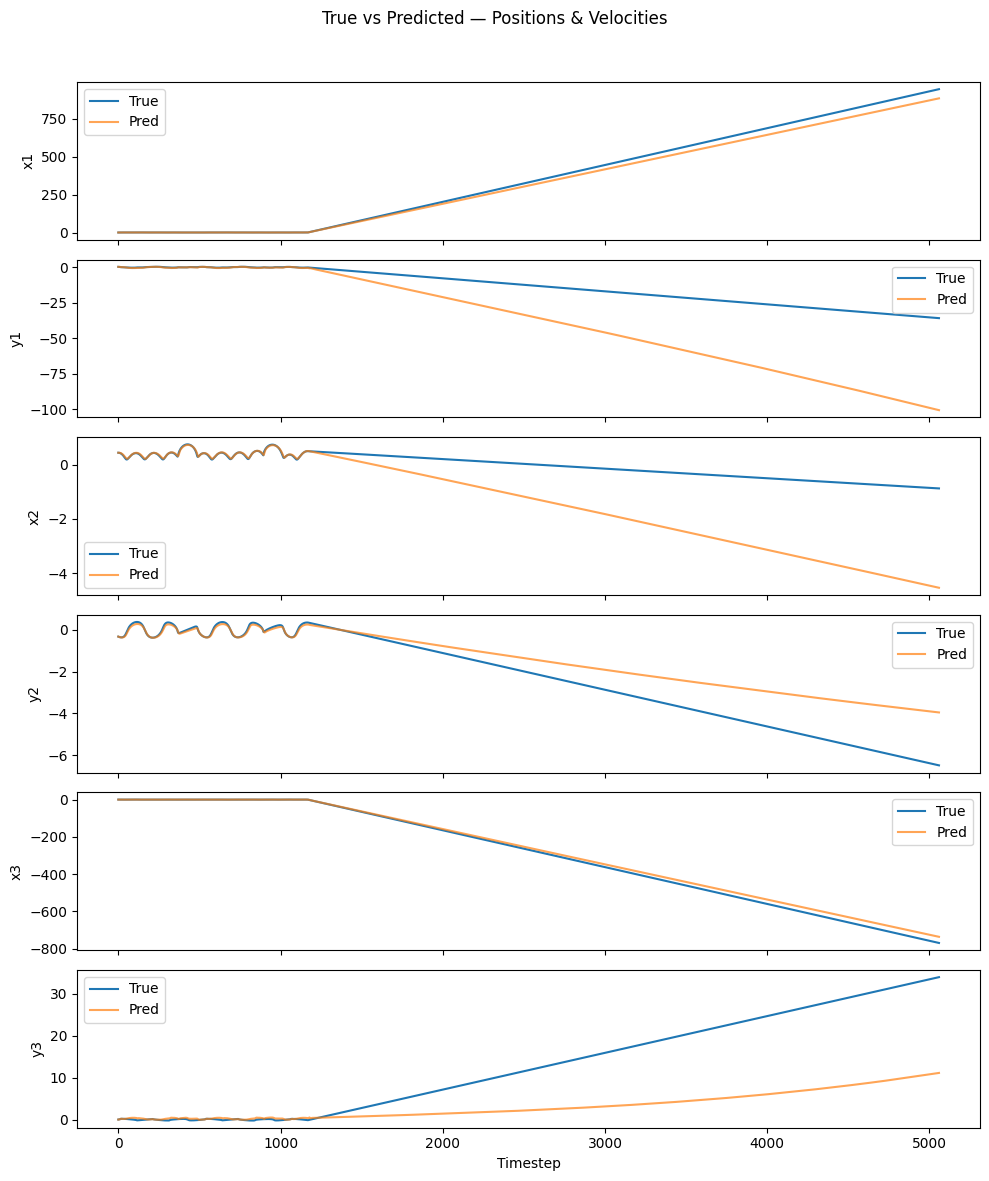

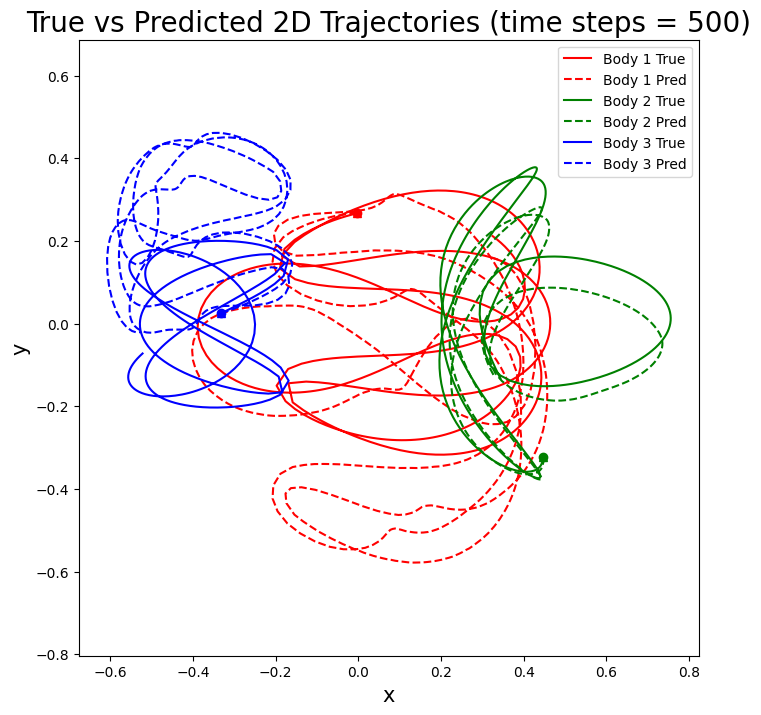

In [160]:
# ─── 7) Prepare one validation run for plotting ─────────────────────────────
import random

# 1) Pick a single run from your validation indices
val_run = random.choice(val_idx)

# 2) Build inputs (drop last step) and scale
val_input = build_inputs(val_run)[:-1]                 # shape (TIMESTEPS-1, INPUT_DIM)
val_scaled = in_scaler.transform(val_input)            # shape (TIMESTEPS-1, INPUT_DIM)

# 3) Reshape for LSTM and predict
val_reshaped   = val_scaled.reshape(1, TIMESTEPS-1, INPUT_DIM)
val_preds_s    = best_model.predict(val_reshaped)[0]   # shape (TIMESTEPS-1, TARGET_DIM)

# 4) Inverse‐scale predictions
val_preds_full = tg_scaler.inverse_transform(val_preds_s)  # (TIMESTEPS-1, 6)

# 5) Get true targets for that run
val_targets_full = X_all[val_run, 1:, :]  # (TIMESTEPS-1, 6)

# 6) Discard washout
val_preds   = val_preds_full[WASHOUT:]    # ((TIMESTEPS-1)-WASHOUT, 6)
val_targets = val_targets_full[WASHOUT:]  # same shape

# 7) Align at t=0
shift = val_targets[0, :6] - val_preds[0, :6]
val_preds += shift

# ─── 8) Plot validation results ──────────────────────────────────────────────
# (a) Positions & velocities over time
fig, axs = plt.subplots(6, 1, figsize=(10, 12), sharex=True)
coords = ['x1', 'y1', 'x2', 'y2', 'x3', 'y3']
for i, ax in enumerate(axs):
    ax.plot(val_targets[:, i], label='True')
    ax.plot(val_preds[:, i],   label='Pred', alpha=0.7)
    ax.set_ylabel(coords[i])
    ax.legend()
axs[-1].set_xlabel('Timestep')
plt.suptitle('True vs Predicted — Positions & Velocities')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# (b) 2D trajectories for first 500 steps
n_plot = 500
tt = val_targets[:n_plot]
pp = val_preds[:n_plot]
fig, ax = plt.subplots(figsize=(8, 8))
colors = ['r', 'g', 'b']
for i, c in enumerate(colors):
    ax.plot(tt[:, 2*i],     tt[:, 2*i+1],   '-',  label=f'Body {i+1} True',  color=c)
    ax.plot(pp[:, 2*i],     pp[:, 2*i+1],   '--', label=f'Body {i+1} Pred',  color=c)
    ax.plot(tt[0, 2*i],     tt[0, 2*i+1],   'o',  color=c)
    ax.plot(pp[0, 2*i],     pp[0, 2*i+1],   '^',  color=c)
ax.set_title(f'True vs Predicted 2D Trajectories (time steps = {n_plot})', fontsize=20)
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('y', fontsize=15)
ax.axis('equal')
ax.legend()
plt.show()


In [156]:
import pandas as pd

# ─── Compute per-timestep MAE & its cumulative sum ────────────────────────────
# val_preds and val_targets are both arrays of shape (T_after_washout, 6)
abs_errors     = np.abs(val_preds - val_targets)    # (T,6)
mae_per_step   = abs_errors.mean(axis=1)            # mean across the 6 dims → (T,)
cumulative_mae = np.cumsum(mae_per_step)            # running sum → (T,)

# ─── Build DataFrame & export to CSV ────────────────────────────────────────
df_error = pd.DataFrame({
    'timestep':        np.arange(len(mae_per_step)),
    'mae':             mae_per_step,
    'cumulative_mae':  cumulative_mae
})


csv_path = 'cumulative_prediction_error_LSTM.csv'
df_error.to_csv(csv_path, index=False)
print(f"Cumulative MAE data saved to {csv_path}")


Cumulative MAE data saved to cumulative_prediction_error_LSTM.csv
